**Importing necessary packages**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
from tqdm import tqdm
import random
%matplotlib inline

**Building Environment class**

In [2]:
#This class is used to represent the race track as the environment

class Environment:
  def __init__(self, track_file, reward=10):
    #Initializing the environment by reading the race track file
    with open(track_file,'r') as f:
      track = f.readlines()

    #Building the environment
    self.arr = self.build_track(track)
    self.m, self.n = self.arr.shape[0], self.arr.shape[1]
    #Initializing the reward for going out of track, collision or reaching goal
    self.reward = reward


  def build_track(self, track):      #Helper function to build the racetrack as environment
    ''' Mapping : 
    0: Start State (S)
    1: Other State (O)
    2: Obstacles State(X)
    3: Finish State(F) 
    '''
    if track[-1]=='\n':
        track.pop()
      
    m = len(track)
      
    arr = []

    for i in range(m-1,-1,-1):
      t = []
      for j in range(len(track[i])):
        if track[i][j]!='\n':
          if track[i][j] =='S':
            t.append(0)
          elif track[i][j] =='O':
            t.append(1)
          elif track[i][j] == 'X':
            t.append(2)
          elif track[i][j] == 'F':
            t.append(3)
      arr.append(t)

    arr = np.array(arr)
    return arr
  
  def plot_track(self):                 #Helper function to plot the race track
    cmap = ListedColormap(['r','gray','k','g'])
    
    t = np.zeros((self.m, self.n))
    for i in range(self.m-1, -1, -1):
      for j in range(self.n):
        t[(self.m-1) - i][j] = self.arr[i][j]

    plt.matshow(t, cmap = cmap)
    #plt.legend()
    plt.axis('off')
    plt.show()

  def plot_episode(self,episode, end_state):      #Helper function to plot an episode of the agent(car)

    t1 = self.arr.copy()
    for ep in episode:
      s = ep[0]
      i,j = s
      t1[i,j] = 4

    if (end_state[0]>=(self.m-1)) and (0<=end_state[1]<self.n):
      t1[self.m-1,end_state[1]] = 4 
    elif (0<=end_state[0]<self.m) and (0<=end_state[1]<self.n):
      t1[end_state[0], end_state[1]] = 4
    
    cmap = ListedColormap(['r','gray','k','g','b'])
    
    t = np.zeros((self.m, self.n))
    for i in range(self.m-1, -1, -1):
      for j in range(self.n):
        t[(self.m-1) - i][j] = t1[i][j]

    plt.imshow(t, cmap = cmap)
    
    plt.axis('off')
    plt.show()

  #Helper function to get the new state of the agent based on it's past state and action chosen 
  def update_state(self, s, a):      
    s_new = (s[0] + a[0], s[1] + a[1])
    return (s_new)

  #Helper function to check if a given state is a terminal state
  def isTerminal(self, s):            #
    i = s[0]
    j = s[1]
    if (i<0) or (j<0) or (j>=self.n) or(i>=self.m):     #went out of racetrack
      return True
    if (self.arr[i,j]==2) or (self.arr[i,j]==3):        #hitting an obstacle or reaching goal
      return True
    
    return False

  #Helper function to get reward for current state
  def get_reward(self,state, hit_obstacle=False):       
    if hit_obstacle ==True:
      return -(self.reward)
    
    i,j = state[0], state[1]
    if (i<0) or (j<0) or (j>=self.n):
      return -(self.reward)
    elif (i>=self.m):
      return self.reward
    elif self.arr[i,j]==3:
      return self.reward
    elif self.arr[i,j]==2:
      return -(self.reward)
    
    
    return -1

  #Helper function to sample a start state for the agent
  def sample_start_state(self):
    j = np.random.randint(0,self.n)
    return (0,j)
    
 

**Q Learning Method**

For this problem, I am going to use the Q-Learning Algorithm. I am going to represent the the agent(car) by the TD_Agent class. The algorithm is implemented by the method Q_L.

In [3]:
#Class to represent the agent(car)
class TD_Agent:
  def __init__(self, epsilon = 0.2):
    #Building the agent with parameters epsilon, the action space possible and initial velocity
    self.epsilon = epsilon
    self.actions = self.actions()
    self.velocity = (0,0)


  def initialize(self, states, env):

    #Initialize  q(s,a) arbitrarily for each state and action except the target state which has q(s,a) = 0
    
    self.q = {}
    
    for s in states:
      for a in self.actions:
        s_a = (s,a)
        
        if (not env.isTerminal(s)):
          self.q[s_a] = np.random.normal(-1,1)
        else:
          self.q[s_a] = 0                 
        

  # Helper function to get the possible actions for a given state  
  def get_action(self,state, learn = True):
    '''learn parameter is used to control if the action sampled should be with respect to if the agent is learning or if it is learnt.
    If agent is learning policy is an epsilon greedy policy. Else, we take the greedy approach of chosing action with max(q(s,a)).
    '''
    if learn==True:
      t = -1
      prob_sample = np.random.uniform(0,1)
      if prob_sample <= self.epsilon:     #to explore
        while True:
          #action = self.actions[np.random.randint(0, len(self.actions))]
          action = random.choice(self.actions)
          if self.action_valid(action):
            a = action
            break
      
      else:           #to exploit
        t = -999 
        best_actions = []
        for action in self.actions:
          x = (state, action)
          
          if (self.q[x]>t) and (self.action_valid(action)):
            best_actions = []
            t = self.q[x]
            best_actions.append(action)
          elif (self.q[x]==t) and (self.action_valid(action)):
            t = self.q[x]
            best_actions.append(action)

        if len(best_actions)>1:
          #t = np.random.randint(0, len(best_actions))
          #a = best_actions[t]
          a = random.choice(best_actions)
        else:
          a = best_actions[0]
    
    else:       #sample action based on learnt agent
      t = -999 
      best_actions = []
      for action in self.actions:
        x = (state, action)
        
        if (self.q[x]>t) and (self.action_valid(action)):
          best_actions = []
          t = self.q[x]
          best_actions.append(action)
        elif (self.q[x]==t) and (self.action_valid(action)):
          #t = self.policy[x]
          best_actions.append(action)

      if len(best_actions)>1:
        #t = np.random.randint(0, len(best_actions))
        #a = best_actions[t]
        a = random.choice(best_actions)
      else:
        a = best_actions[0]



    return a

  #Helper function to check if action chosen is a valid action with respect to agent constraints
  def action_valid(self, a):
    vx = self.velocity[0] + a[0]
    vy = self.velocity[1] + a[1]

    if (vx==0 and vy==0):   #velocity cannot be zero except at start position
      return False

    if (np.abs(vx)<5) and (np.abs(vy)<5):       #absolute value of each velocity component must be less than 5
      return True
    
    return False

  #Helper function to update velocity of agent(car)
  def update_velocity(self, a):
    vx = self.velocity[0] + a[0]
    vy = self.velocity[1] + a[1]
    self.velocity = (vx, vy)

  #Helper function to reset car velocity after end of episode
  def reset_car(self):
    self.velocity = (0,0)

  #Helper function to chose greedily the action which gives max(q(s,a)) for a given state  
  def get_a_star(self, s):
    t = -999
    best_actions = []
    for a in self.actions:
      state = (s,a)
      if self.q[state] > t:
        best_actions = []
        t = self.q[state]
        best_actions.append(a)
      elif self.q[state]==t:
        best_actions.append(a)
    
    if len(best_actions)>1:
      a_star = random.choice(best_actions)
    else:
      a_star = best_actions[0]

    return a_star

  #helper function to build possible actions of the agent based on the problem statement
  def actions(self):
    possible_actions = [-1, 0, 1] # -1:decrease velocity by one, 0: keep velocity unchanged, 1: increase velocity by 1
    return (list(itertools.product(possible_actions, possible_actions)))  
    
  



  

In [4]:
#Function to determine if a move of the agent from state s to state s_new causes a collision. 
def move_hit_obstacle(env, s, s_new):
  x_a, y_a = s
  x_b, y_b = s_new

  if x_a > x_b:
    min_x, max_x = x_b, x_a
  else:
    min_x, max_x = x_a, x_b

  if y_a > y_b: 
    min_y, max_y = y_b, y_a
  else:
    min_y, max_y = y_a, y_b

  dx = (max_x - min_x) + 1
  dy = (max_y - min_y) + 1
  t = env.arr[min_x:(min_x + dx),min_y:(min_y+dy)]
  
  for elem in t.flatten():
    if elem==2:
      return True
  return False

In [ ]:
last_ep = None

In [5]:
#Function to implement the Q-Learning algorithm
def Q_L(agent, env, alpha = 0.5,discount_factor = 0.9, epsilon = 0.2, episodes = 50000, goals_desired = 10000):
  global last_ep
  
  #Initialize Q(S,A)
  states = list(itertools.product(range(env.m), range(env.n)))
  agent.initialize(states,env)

  episode_number = 0
  goals_crossed = 0
  

  for episode_number in tqdm(range(episodes)):

    start_state = env.sample_start_state()
    
    s = start_state
    a = agent.get_action(s)
    agent.update_velocity(a)
    r = env.get_reward(s)

    episode = [(s,a,r)]
    
    s_new = env.update_state(s, agent.velocity)
    hit_obstacle = move_hit_obstacle(env, s,s_new)

    while (not env.isTerminal(s_new)) and (not hit_obstacle):
      
      a_star = agent.get_a_star(s_new)
      agent.q[(s,a)] = agent.q[(s,a)] + alpha*(r + (discount_factor* agent.q[(s_new, a_star)]) - agent.q[(s,a)])


      r = env.get_reward(s_new)
      s = s_new
      a = agent.get_action(s)
      agent.update_velocity(a)

      s_new = env.update_state(s, agent.velocity)
      hit_obstacle = move_hit_obstacle(env,s,s_new)
      episode.append((s,a,r))
    
    #Final Terminal state reward
    
    agent.q[(s,a)] = agent.q[(s,a)] + alpha*(r + (discount_factor * env.get_reward(s_new,hit_obstacle)) - agent.q[(s,a)])     

    agent.reset_car()
    
    if hit_obstacle==False:
      if s_new[0]>=env.m:        #acceleration caused car to go out of track crossing the finish line meanwhile
        goals_crossed+=1
        last_ep = (episode,s_new)
      
      if (0<=s_new[0]<env.m) and (0<=s_new[1]<env.n):
        if env.arr[s_new[0], s_new[1]] == 3:
          goals_crossed +=1
          last_ep = (episode,s_new)

    
    if goals_crossed >=goals_desired:
      print ("Goals crossed surpassed goals desired to stop. Stopping Learning!")
      #last_ep = (episode,s_new)
      break
    
  return goals_crossed

**Track 1**

Building the environment for track 1 and applying the Q learning algorithm for the agent on this environment.

Note: I took a steeper reward of 30 and penalty 30 for track 1 as a reward of 10 and penalty of 10 was causing the algorithm to take a lot more time to converge to 10K episodes where agent crossed goal state. 

In [6]:
env = Environment('track-1.txt', reward = 30)
td_agent = TD_Agent()
Q_L(td_agent, env, alpha = 0.6, epsilon = 0.2, discount_factor = 0.95, episodes = 5000000)

 59%|█████▉    | 2974296/5000000 [14:44<08:36, 3924.67it/s]

Goals crossed surpassed goals desired to stop. Stopping Learning!


10000

We can see that the agent crossed the goal state 10K times after about 2.9M episode. So, we stop the algorithm there and plot an episode of the agent to see how it learnt.

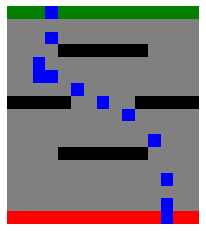

In [9]:
episode, end_state = last_ep
end_reward = env.get_reward(end_state)
env.plot_episode(episode, end_state)

From the plot, we can clearly see that the agent is successfully navigating itself across the racetrack by avoiding obstacles while maintaining the system and agent constraints. Here, **red = Start, Black = Obstacle, Green = Finish, Blue = Car trajectory**. I am also showing the trace of the car along the whole episode below. 

In [9]:

def show_trace(episode, end_state, end_reward):
  trace = {'Time': [], 'State': [], 'Action': [], 'Reward':[]}
  for i, ep in enumerate(episode):
    s, a, r = ep
    trace['Time'].append(i+1)
    trace['State'].append(s)
    trace['Action'].append(a)
    trace['Reward'].append(r)

  trace['Time'].append(len(episode)+1)
  trace['State'].append(end_state)
  trace['Action'].append("X")
  trace['Reward'].append(end_reward)

  result = pd.DataFrame(trace)
  print (result)



In [27]:
show_trace(episode, end_state, end_reward)

    Time    State    Action  Reward
0      1  (0, 12)    (1, 0)      -1
1      2  (1, 12)    (1, 0)      -1
2      3  (3, 12)   (1, -1)      -1
3      4  (6, 11)  (-1, -1)      -1
4      5   (8, 9)   (-1, 0)      -1
5      6   (9, 7)    (0, 0)      -1
6      7  (10, 5)    (0, 0)      -1
7      8  (11, 3)   (-1, 1)      -1
8      9  (11, 2)    (1, 1)      -1
9     10  (12, 2)    (1, 1)      -1
10    11  (14, 3)   (1, -1)      -1
11    12  (17, 3)         X      30


From above we can see the trace of the car with the actions and rewards across the time steps.

**Track 2**

Now, we build the environment as the environment of track 2 and run our algorithm for a new agent to learn from this environment.

In [6]:
env = Environment('track-2.txt', reward = 50)
td_agent = TD_Agent()
Q_L(td_agent, env, alpha = 0.6, epsilon = 0.3, discount_factor = 0.95, episodes = 50000000)

 20%|█▉        | 9791817/50000000 [49:35<3:51:49, 2890.64it/s]

Goals crossed surpassed goals desired to stop. Stopping Learning!


10000

We can see that after around 9.7M episodes, the agent finally converged having crossed the goal state 10K times. We stop the algorithm here.

Note: I took a further higher reward and penalty of 50 for this track. Taking less reward value would take more time. 

Below, the plot shows the agent navigating around the race track 2 while maintaining the action constraints. The trace for the same is also shown:

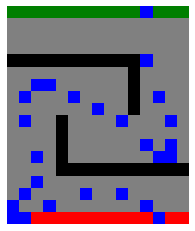

In [7]:
episode, end_state = last_ep
end_reward = env.get_reward(end_state)
env.plot_episode(episode, end_state)

In [9]:
show_trace(episode, end_state, end_reward)

    Time     State    Action  Reward
0      1   (0, 12)   (1, -1)      -1
1      2   (1, 11)   (0, -1)      -1
2      3    (2, 9)  (-1, -1)      -1
3      4    (2, 6)   (-1, 0)      -1
4      5    (1, 3)    (0, 1)      -1
5      6    (0, 1)    (1, 1)      -1
6      7    (0, 0)    (1, 1)      -1
7      8    (1, 0)    (0, 1)      -1
8      9    (2, 1)    (0, 0)      -1
9     10    (3, 2)   (1, -1)      -1
10    11    (5, 2)   (1, -1)      -1
11    12    (8, 1)   (-1, 1)      -1
12    13   (10, 1)   (-1, 1)      -1
13    14   (11, 2)   (-1, 0)      -1
14    15   (11, 3)   (-1, 1)      -1
15    16   (10, 5)    (0, 0)      -1
16    17    (9, 7)    (0, 0)      -1
17    18    (8, 9)   (-1, 0)      -1
18    19   (6, 11)   (1, -1)      -1
19    20   (5, 12)    (1, 0)      -1
20    21   (5, 13)   (1, -1)      -1
21    22   (6, 13)    (1, 0)      -1
22    23   (8, 13)   (0, -1)      -1
23    24  (10, 12)    (1, 0)      -1
24    25  (13, 11)    (1, 1)      -1
25    26  (17, 11)         X      50


**Track 3**

This track is a custom and shorter track built to test out the algorithm for the problem statement.

As the track is relatively simpler, we keep the reward and penalty value as 10 and increase the number of times required to cross goal state to 20K. The algorithm converges suitably after about 0.4M episodes. The plot of the car navigating the track and it's corressponding trace is shown below: 

In [6]:
td_agent = TD_Agent()
env = Environment('test_track.txt', reward = 10)
Q_L(td_agent, env, alpha = 0.5, episodes = 5000000, goals_desired = 20000)

  9%|▊         | 432884/5000000 [01:29<12:47, 5954.01it/s]

Goals crossed surpassed goals desired to stop. Stopping Learning!


20000

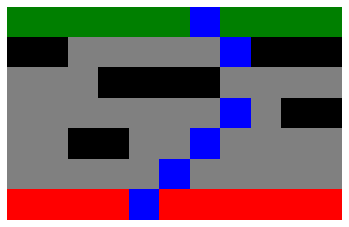

In [7]:
episode, end_state = last_ep
end_reward = env.get_reward(end_state)
env.plot_episode(episode, end_state)

In [10]:
show_trace(episode, end_state, end_reward)

   Time   State   Action  Reward
0     1  (0, 4)   (1, 1)      -1
1     2  (1, 5)   (0, 0)      -1
2     3  (2, 6)   (0, 0)      -1
3     4  (3, 7)  (1, -1)      -1
4     5  (5, 7)  (1, -1)      -1
5     6  (8, 6)        X      10
